# NOTEBOOK 5: CASES ANALYSIS


# TODO: PROVARE 
- SELECT SENSIBLE VARIABLES AND ANALYZE THOSE ONLY !! 
- PROVARE SOLO I DUE GRUPPI ESTREMI OPPURE UP VS LOW

In [1]:
# IMPORTING STATEMENTS
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


np.random.seed(7)


print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.2.1-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
Pandas 2.0.0
Scikit-Learn 1.2.2
GPU is available


# Import Data

In [2]:
# Import true y

data_test = pd.read_csv('../0_data/test.csv', index_col=0).reset_index(drop=True)
y_true = np.array(data_test.pop('InterestRate'))

In [3]:
# Import Predictions
path = '../3_analysis/predictions/'    # path of folder

In [4]:
# LATER !!!!


# Import predictions from csv files, which have been rescaled to the original scale
#forest_pred = pd.read_csv(path + 'RandomForest_pred.csv', header=None)
#xgbr_pred = pd.read_csv(path + 'XGBoost_pred.csv', header=None)
#lgbm_pred = pd.read_csv(path + 'LightGBM_pred.csv', header=None)

# TODO: Models Selected

In [15]:
models = ['LinearRegression', # TODO: ADD OTHER
          'RandomForest',
          'HybridModel'
         ]


# Helper functions

In [16]:
def identify_cases(y_true, y_pred, threshold=0.25):
    """
    Identify four cases based on the comparison of y_pred and y_true with a threshold.
    Returns a dictionary containing four lists of indices for each case.
    """
    # Calculate the absolute difference between y_pred and y_true
    diff = y_pred - y_true

    # Create masks for the four cases
    mask_case1 = (diff <= - threshold)               # prediction far too low
    mask_case2 = (diff < 0) & (diff > - threshold)
    mask_case3 = (diff > 0) & (diff < threshold)
    mask_case4 = (diff >= threshold)                 # prediction far too high

    # Identify the indices for each case
    case1_indices = np.where(mask_case1)[0]
    case2_indices = np.where(mask_case2)[0]
    case3_indices = np.where(mask_case3)[0]
    case4_indices = np.where(mask_case4)[0]

    # Print the percentages of data points in each case
    n_y = len(y_pred)
    print(f"Case 1 (y_pred < y_true by at least {str(threshold)}): {mask_case1.sum()/n_y*100 :.3f}%")    # {z:.2f}
    print(f"Case 2 (y_pred < y_true by no more than {str(threshold)}): {sum(mask_case2)/n_y*100 : .2f}%")
    print(f"Case 3 (y_pred > y_true by no more than {str(threshold)}): {sum(mask_case3)/n_y*100 : .2f}%")
    print(f"Case 4 (y_pred > y_true by at least {str(threshold)}): {sum(mask_case4)/n_y*100 : .2f}%")

    # Create a dictionary to store the indices for each case
    cases = {
        '1': case1_indices,
        '2': case2_indices,
        '3': case3_indices,
        '4': case4_indices,
    }

    return cases

def add_cases(indexes, data_test, name_col='case'):
    data_test[name_col] = [1 if i in indexes['1'] else 2 if i in indexes['2'] 
                        else 3 if i in indexes['3'] else 4 if i in indexes['4'] else 0 
                           for i in range(len(data_test))]
    return data_test

# Predictions and Analysis

For each model, we first import the predictions and run analyses to uncover potential discriminations. 

## 1. PICK MODEL & visualize predictions vs true

In [17]:
# CASES
model = models[2]    #for model in models:
y_pred = pd.read_csv(str(path)+str(model)+'_pred.csv', header=None)
y_pred = y_pred[0].values

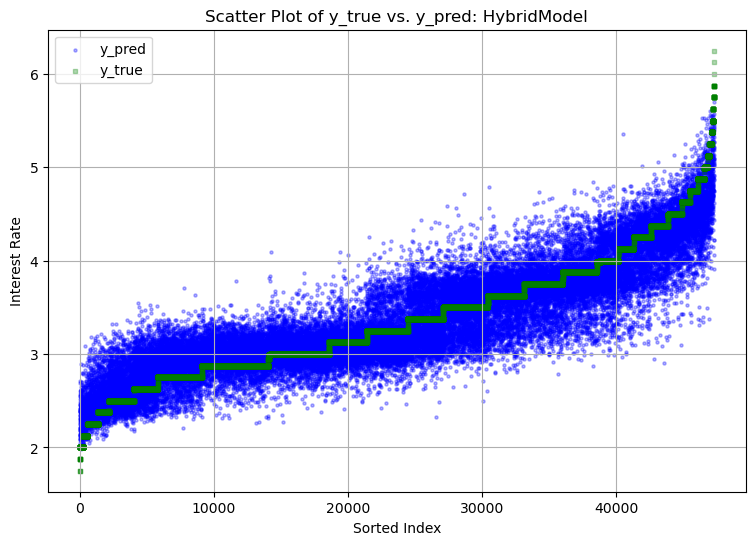

In [18]:
# Sort the data and get the sorted indices
sorted_indices = np.argsort(y_true)

# Sort y_true and y_pred based on the sorted indices
y_true_sorted = np.array(y_true)[sorted_indices]
y_pred_sorted = np.array(y_pred)[sorted_indices]

# Create a scatterplot
plt.figure(figsize=(9, 6))
plt.scatter(range(len(y_true_sorted)), y_pred_sorted, c='blue', marker='o', label='y_pred', alpha=0.3, s=5)
plt.scatter(range(len(y_true_sorted)), y_true_sorted, c='green', marker='s', label='y_true', alpha=0.3, s=5)
plt.xlabel('Sorted Index')
plt.ylabel('Interest Rate')
plt.title('Scatter Plot of y_true vs. y_pred: '+ model)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## 2.1 cases

In [19]:
indexes = identify_cases(y_true, y_pred)

Case 1 (y_pred < y_true by at least 0.25): 15.754%
Case 2 (y_pred < y_true by no more than 0.25):  31.93%
Case 3 (y_pred > y_true by no more than 0.25):  36.69%
Case 4 (y_pred > y_true by at least 0.25):  15.62%


In [20]:
data_test = add_cases(indexes, data_test, name_col=model)



# TODO: NUMERICAL VARIABLES
- for var in num_vars: if pvalue > 0.5 print "Found difference and plot box plots"



The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

The samples are independent.

Each sample is from a normally distributed population.

The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

If these assumptions are not true for a given set of data, it may still be possible to use the Kruskal-Wallis H-test (scipy.stats.kruskal) or the Alexander-Govern test (scipy.stats.alexandergovern) although with some loss of power.

W. H. Kruskal & W. W. Wallis, “Use of Ranks in One-Criterion Variance Analysis”, Journal of the American Statistical Association, Vol. 47, Issue 260, pp. 583-621, 1952.



In [21]:
numerical = pd.read_csv('../0_data/numerical.csv', index_col=0)['0'].values

In [29]:
numerical

array(['InterestRate', 'MinorityRatio', 'CensusTractMedFamIncome',
       'MonthlyIncome', 'HUDMedIncome', 'LTV', 'PaymentCount', 'Age1',
       'Age2', 'HousingExpense', 'DebtExpense', 'PMI', 'CreditScore1',
       'CreditScore2', 'NoteDate', 'NoteAmount'], dtype=object)



MinorityRatio: found a statistical difference in the means, with p value: 7.120417393019842e-24

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 1 and Dataset 4
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


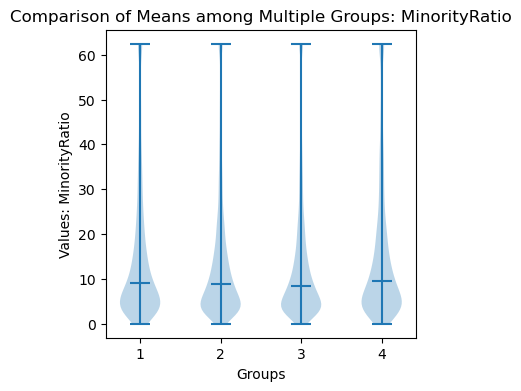



CensusTractMedFamIncome: found a statistical difference in the means, with p value: 1.0897161866928152e-11

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


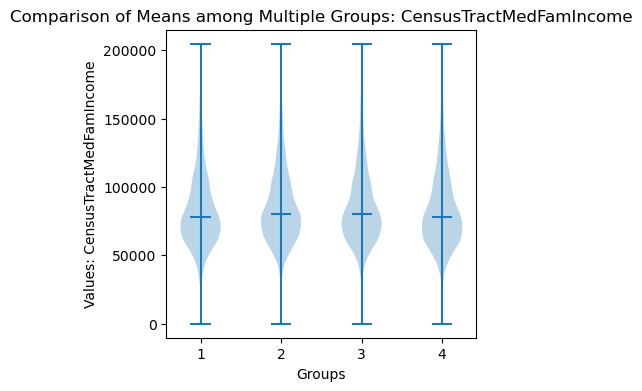



MonthlyIncome: found a statistical difference in the means, with p value: 0.006338596815785657

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 1 and Dataset 4
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


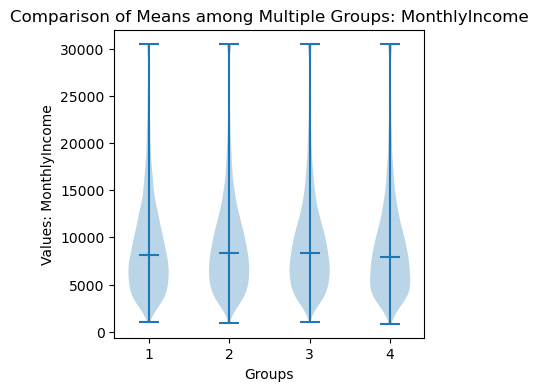



HUDMedIncome: found a statistical difference in the means, with p value: 4.548365439744516e-08

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


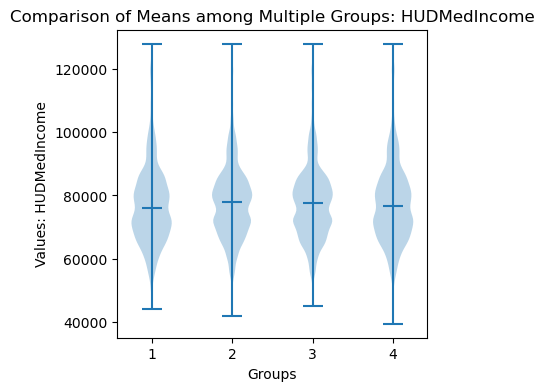



LTV: found a statistical difference in the means, with p value: 4.397287552501709e-51

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 1 and Dataset 4
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


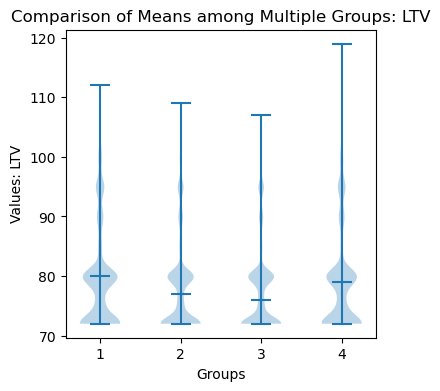



PaymentCount: found a statistical difference in the means, with p value: 4.6925274773314016e-40

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


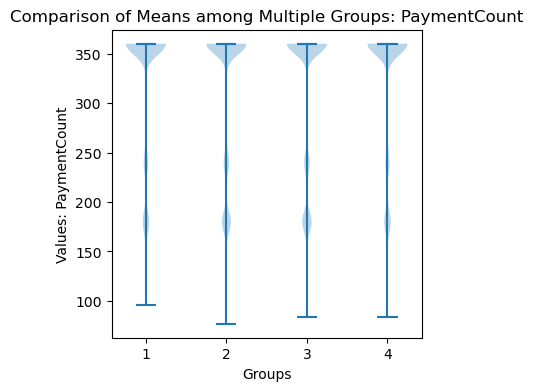



Age2: found a statistical difference in the means, with p value: 3.481927572692504e-11

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


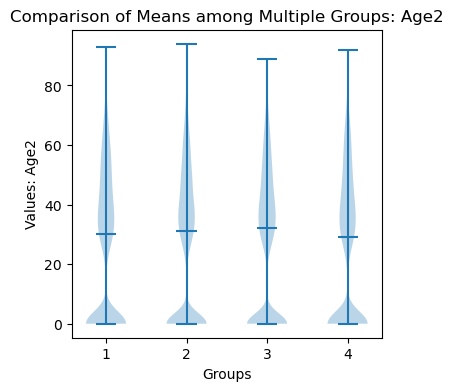



HousingExpense: found a statistical difference in the means, with p value: 1.1010265407982006e-11

There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


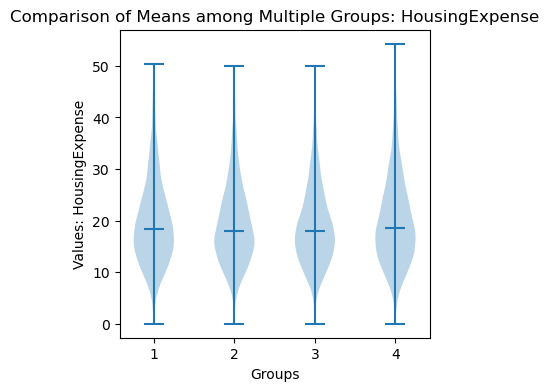



DebtExpense: found a statistical difference in the means, with p value: 8.62535089687319e-38

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


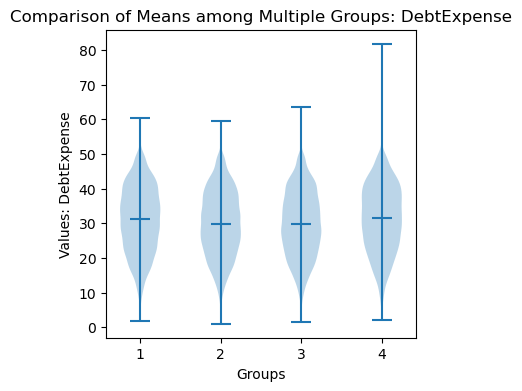



PMI: found a statistical difference in the means, with p value: 4.113397860791865e-07

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3


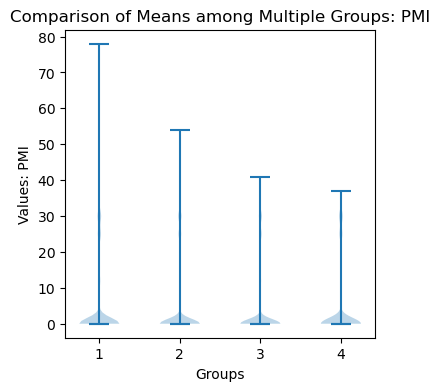



CreditScore1: found a statistical difference in the means, with p value: 2.535829433360756e-119

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


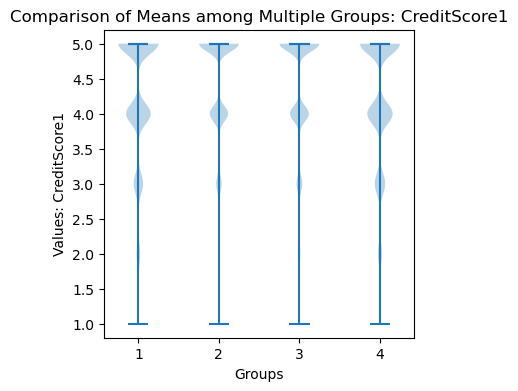



CreditScore2: found a statistical difference in the means, with p value: 4.610536883733562e-05

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


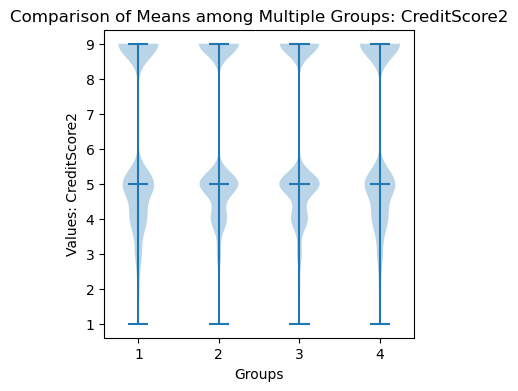



NoteDate: found a statistical difference in the means, with p value: 3.107492018574917e-86

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


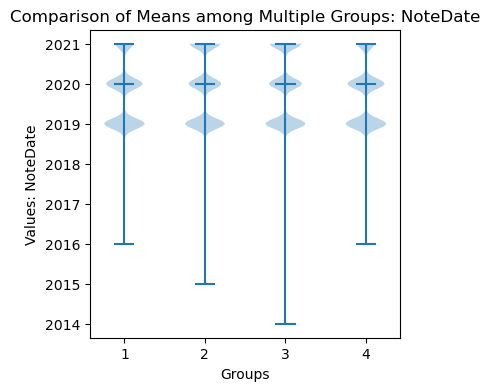

In [27]:
counter, different_vars = 0, []
for var_name in numerical[1:]: 

    data = {'Group1': data_test.loc[indexes['1'],var_name].dropna().tolist(),
            'Group2': data_test.loc[indexes['2'],var_name].dropna().tolist(),
            'Group3': data_test.loc[indexes['3'],var_name].dropna().tolist(),
            'Group4': data_test.loc[indexes['4'],var_name].dropna().tolist()}
    
    # Perform ANOVA test
    h_statistic, p_value = stats.kruskal(data['Group1'], data['Group2'], data['Group3'], data['Group4'])    # f_oneway

    if p_value < 0.1: 
        counter +=1
        different_vars.append(var_name)
        print(f"\n\n{var_name}: found a statistical difference in the means, with p value: {p_value}\n") 
        
        
        # Perform pairwise KS tests
        data = [data['Group1'], data['Group2'], data['Group3'], data['Group4']]
        for i, dataset1 in enumerate(data):
            for j, dataset2 in enumerate(data):
                if i < j:
                    ks_statistic, p_value = stats.ks_2samp(dataset1, dataset2)
                    '''print(f"KS Test between Dataset {i+1} and Dataset {j+1}:")
                    print(f"KS Statistic: {ks_statistic}")
                    print(f"P-value: {p_value}")'''
                    if p_value < 0.05:  # Set your desired significance level
                        print(f"There is evidence of a difference in distributions between Dataset {i+1} and Dataset {j+1}")
                    else:
                        pass #print("No significant difference in distributions.\n")

        
        
        # plot box plots 
        #data = [data['Group1'], data['Group2'], data['Group3'], data['Group4']]
        plt.figure(figsize=(4, 4))
        plt.violinplot(data, showmedians=True, showmeans=False)#, labels=['Case 1', 'Case 2', 'Case 3', 'Case 4'])
        plt.xlabel("Groups")
        plt.ylabel("Values: "+var_name)
        plt.title("Comparison of Means among Multiple Groups: "+var_name)
        plt.show()
        

In [28]:
print(f"Statistical difference in means found in {counter} variables: \n{different_vars}")

Statistical difference in means found in 13 variables: 
['MinorityRatio', 'CensusTractMedFamIncome', 'MonthlyIncome', 'HUDMedIncome', 'LTV', 'PaymentCount', 'Age2', 'HousingExpense', 'DebtExpense', 'PMI', 'CreditScore1', 'CreditScore2', 'NoteDate']


In [10]:
data.head()

,Group1,Group2,Group3,Group4
0,NaN,47.950,NaN,NaN
1,NaN,6.489,NaN,NaN
2,NaN,NaN,NaN,9.661
3,NaN,5.172,NaN,NaN
4,4.396,NaN,NaN,NaN



# TODO: CATEGORICAL VARIABLES
- add statistical test
- plot graph only if statistically significant numerical difference is detected

In [32]:
categorical = pd.read_csv('../0_data/categorical_enc.csv', index_col=0)['0'].values

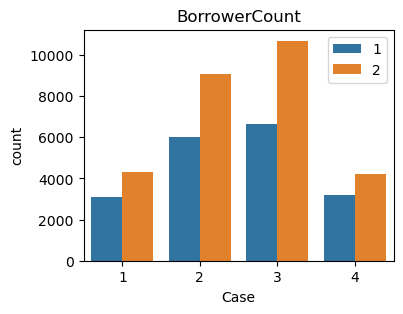

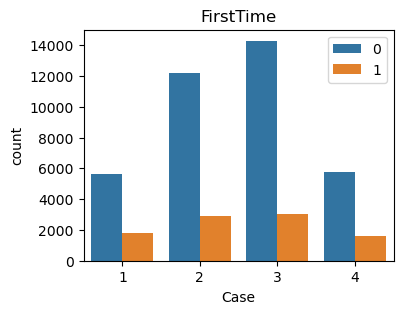

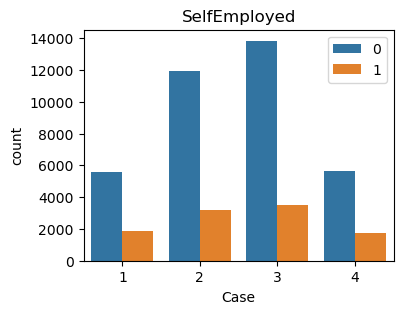

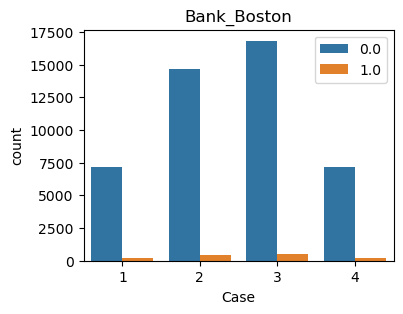

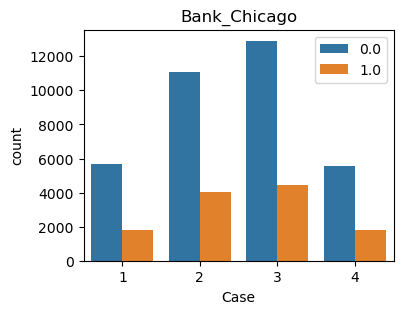

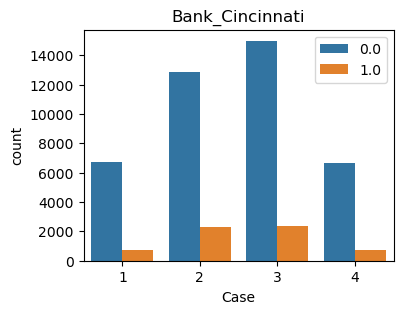

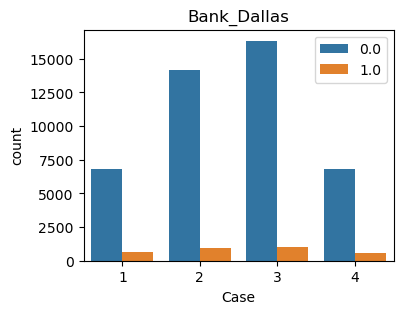

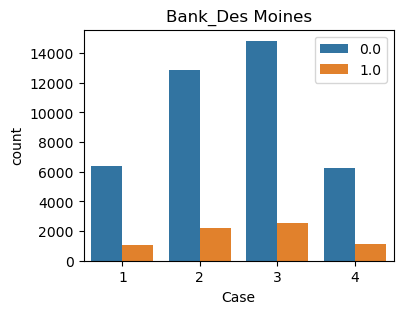

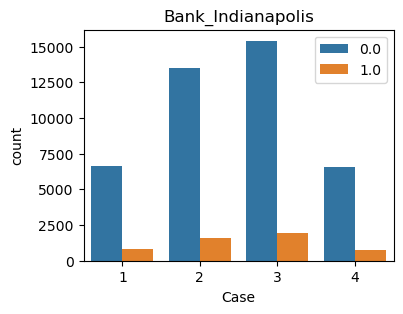

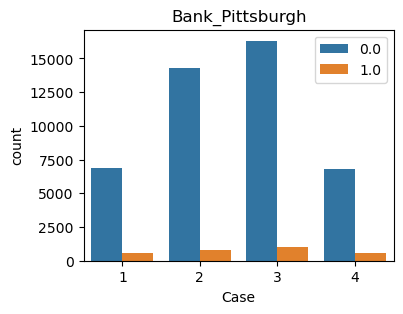

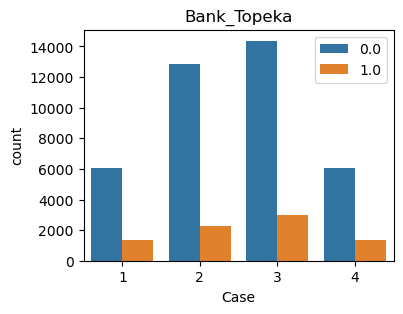

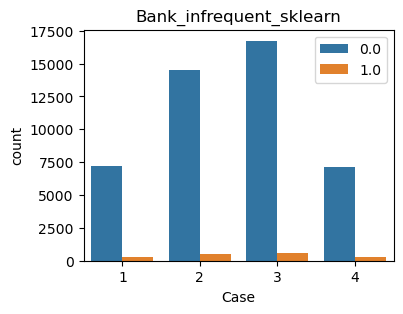

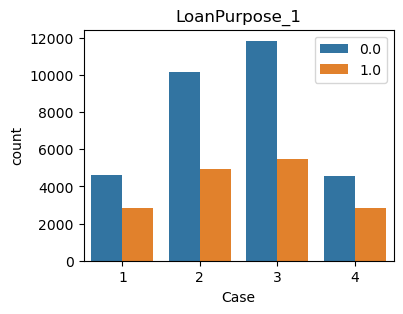

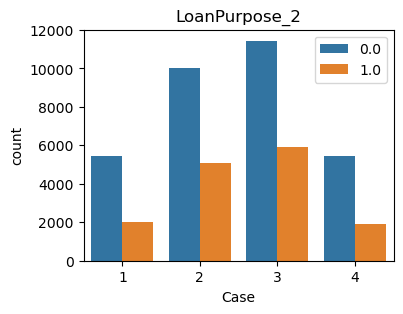

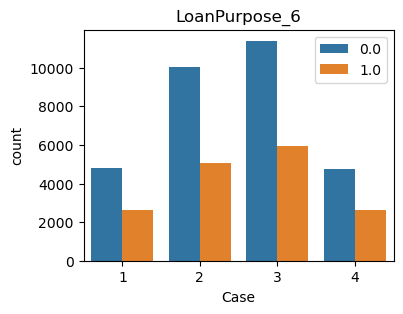

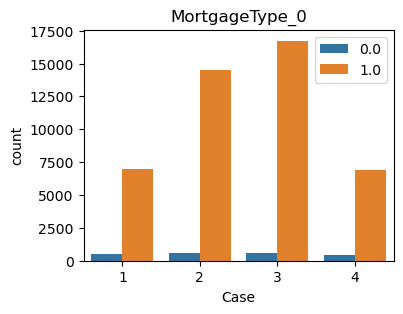

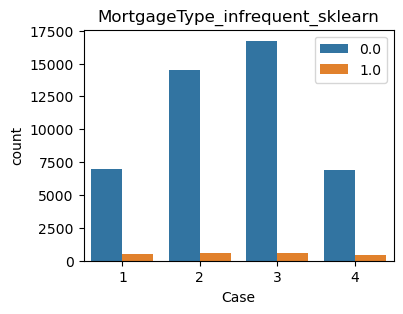

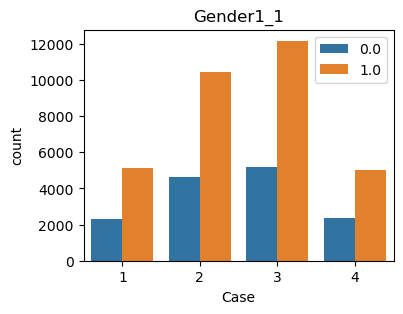

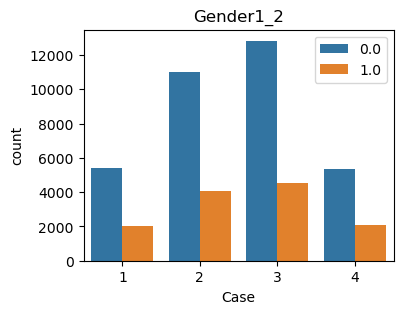

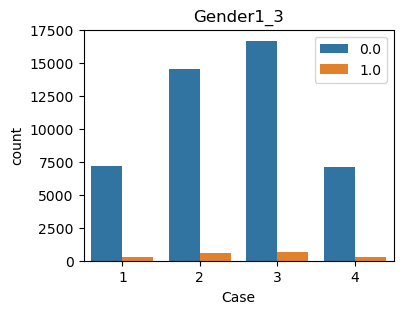

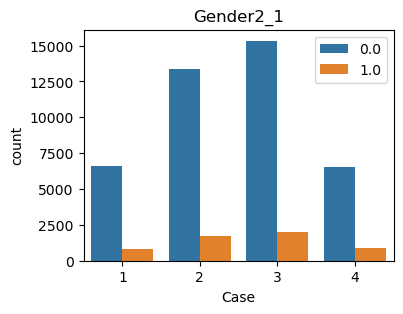

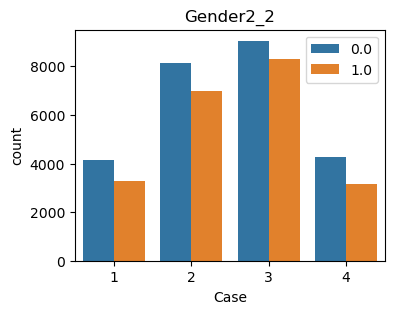

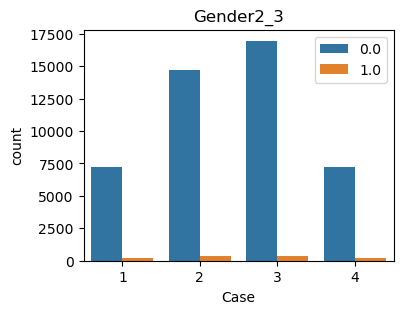

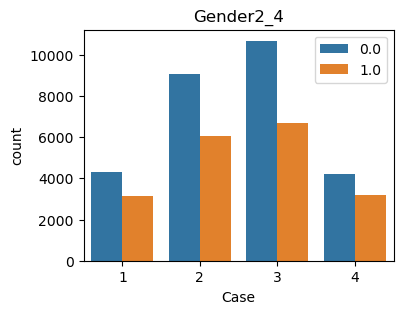

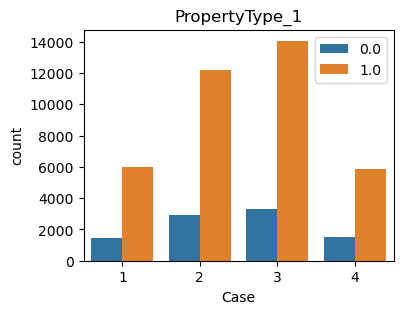

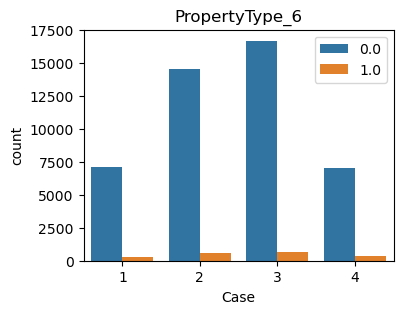

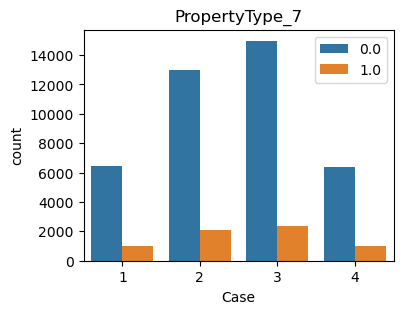

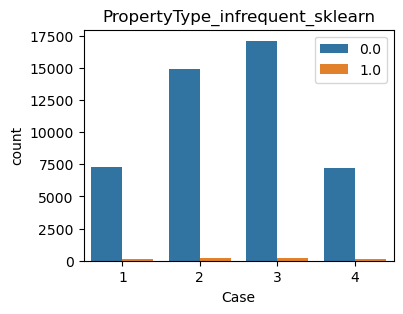

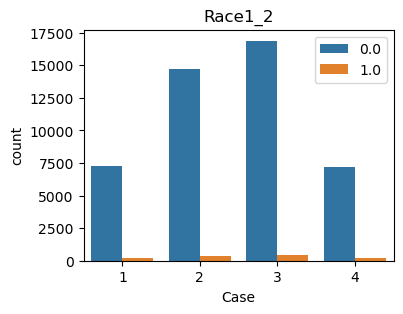

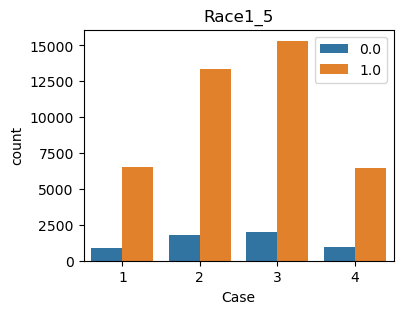

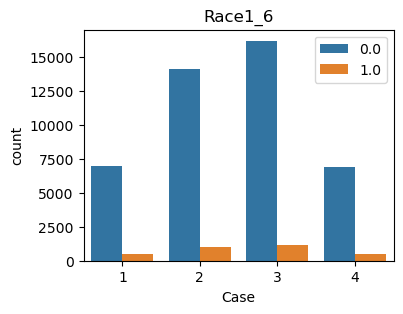

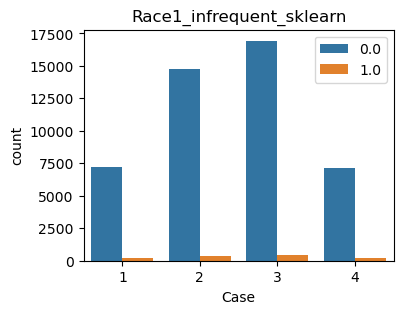

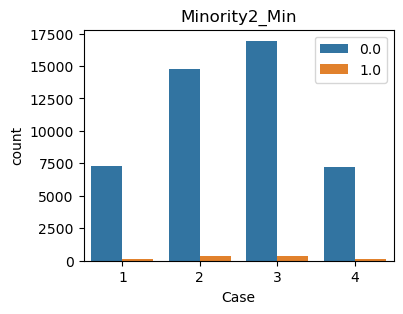

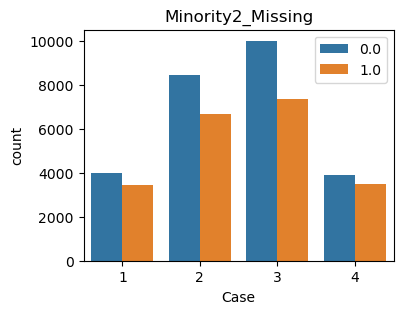

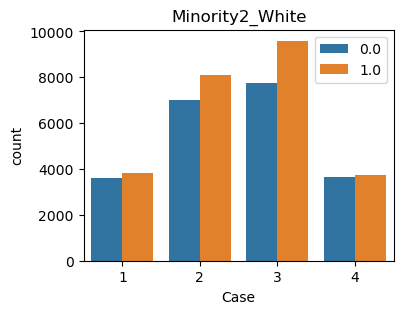

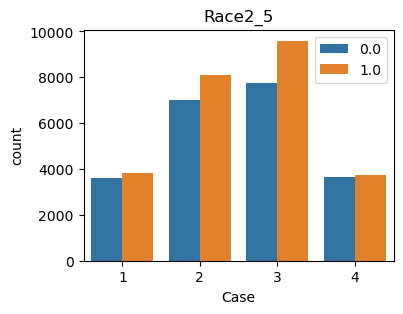

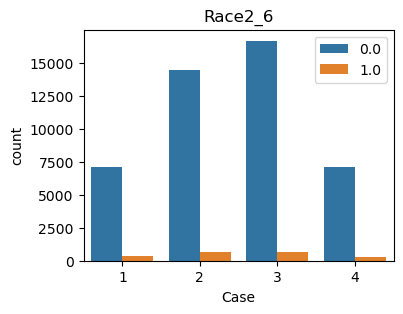

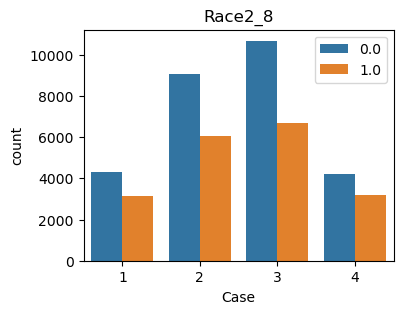

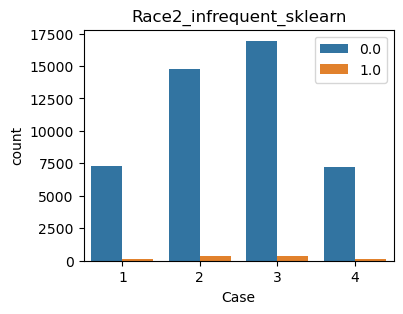

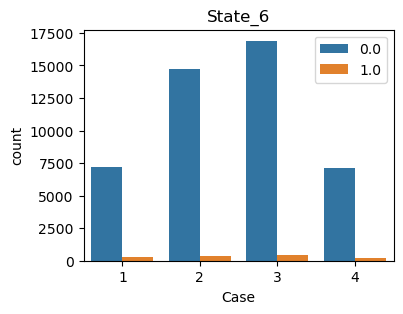

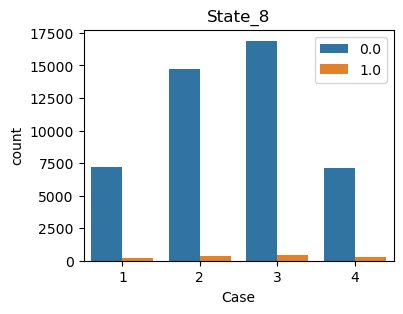

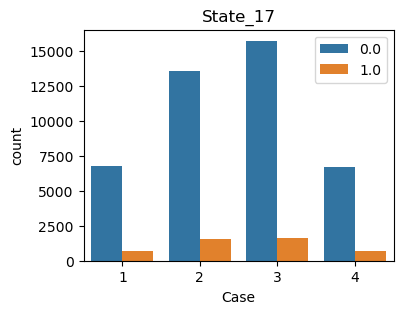

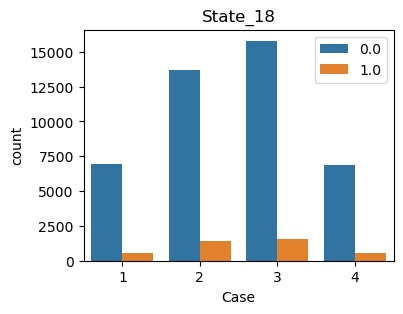

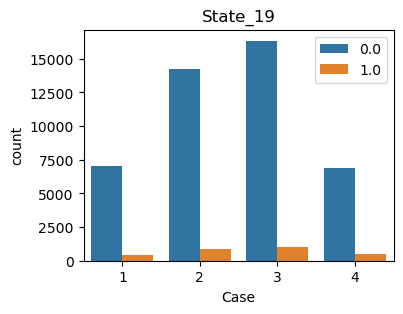

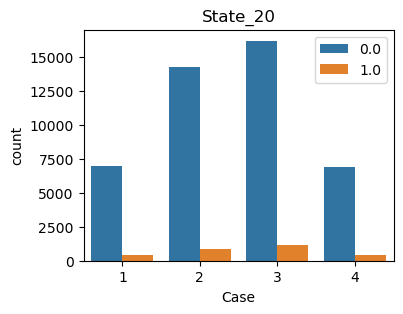

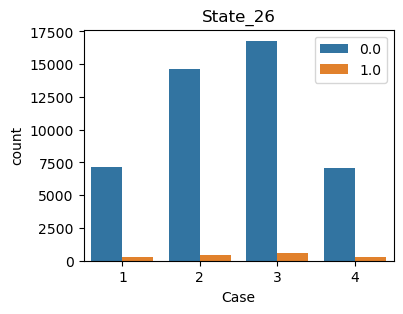

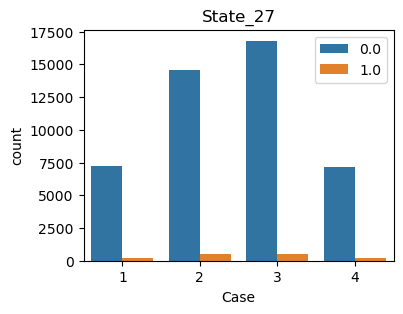

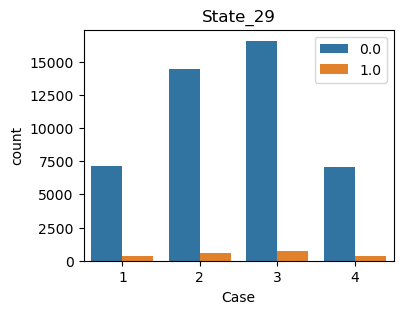

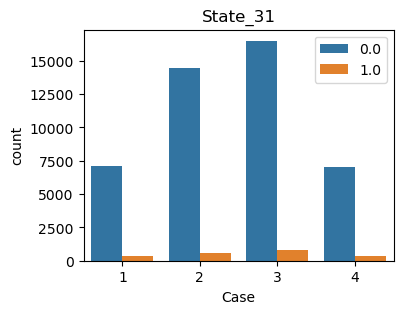

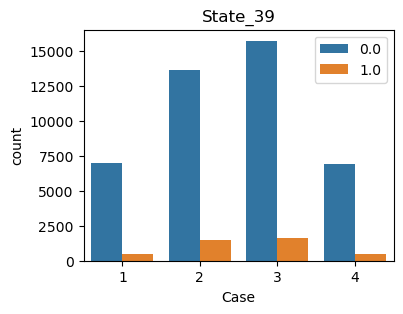

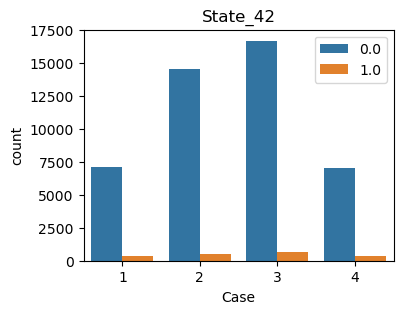

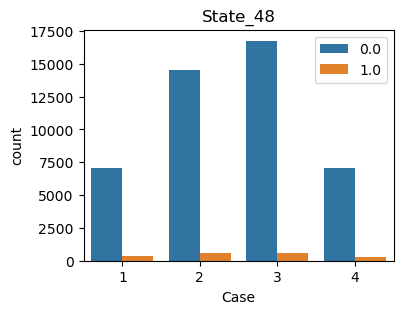

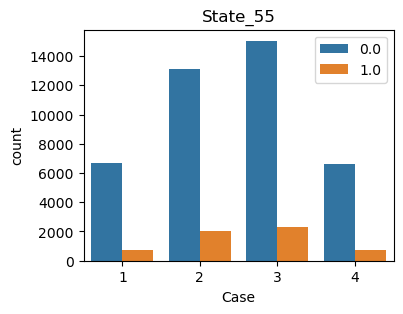

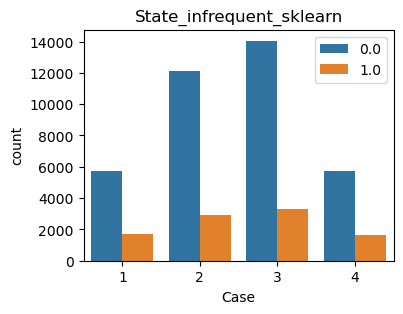

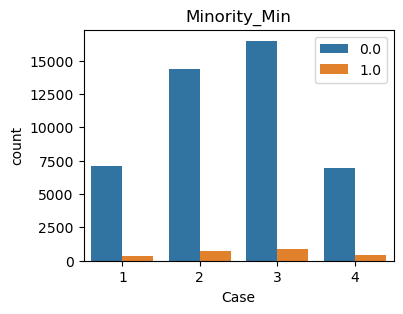

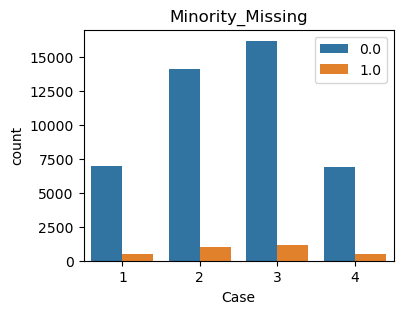

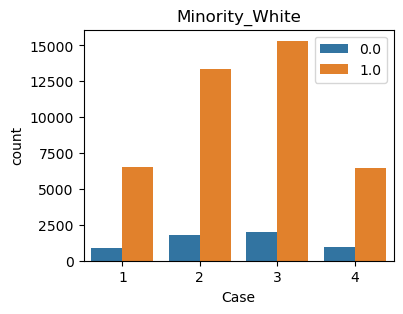

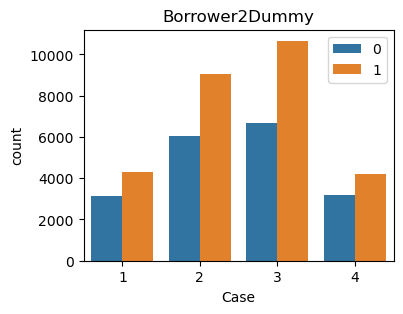

In [33]:
for var_name in categorical:
    plt.figure(figsize=(4,3))
    ax = sns.countplot(x=model, data=data_test, hue=var_name) 
    plt.title(var_name) 
    plt.xlabel('Case')
    plt.legend(title=None)
    plt.show()



BorrowerCount: found a statistical difference in the means, with p value: 3.4946758344919586e-13

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


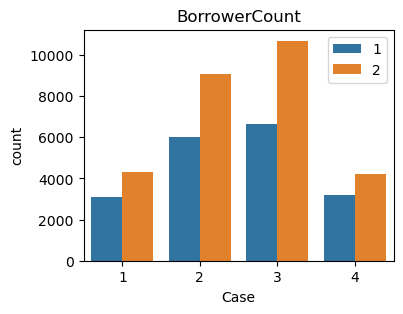



FirstTime: found a statistical difference in the means, with p value: 4.321271901128356e-36

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 1 and Dataset 4
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


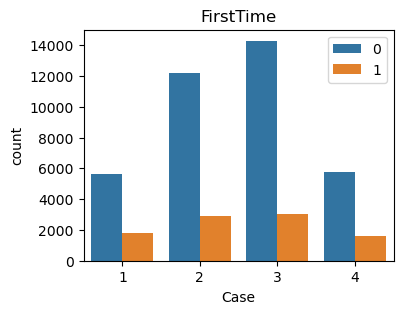



SelfEmployed: found a statistical difference in the means, with p value: 1.9214615649149784e-17

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


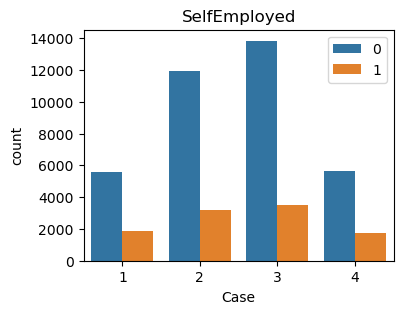



Bank_Chicago: found a statistical difference in the means, with p value: 1.527654054058041e-05

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


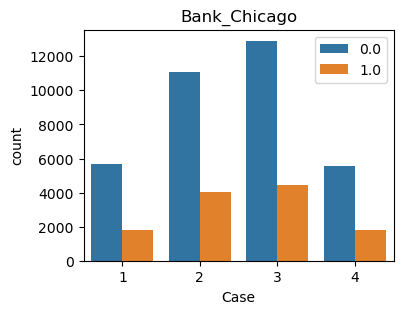



Bank_Cincinnati: found a statistical difference in the means, with p value: 5.903034220242585e-48

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


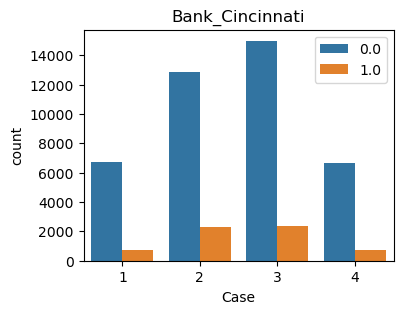



Bank_Dallas: found a statistical difference in the means, with p value: 1.4650616187394008e-16

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


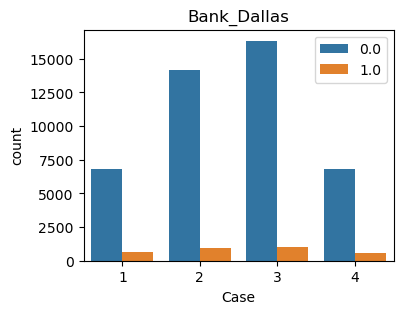



Bank_Pittsburgh: found a statistical difference in the means, with p value: 1.016755549224646e-17

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


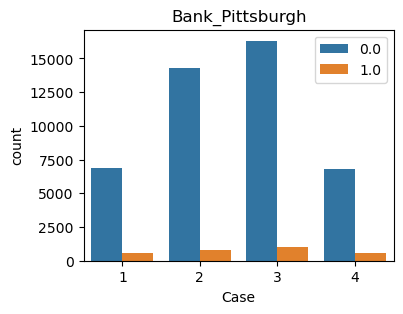



Bank_Topeka: found a statistical difference in the means, with p value: 2.3192131876037993e-13

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4


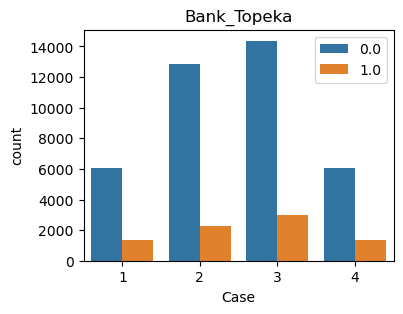



LoanPurpose_1: found a statistical difference in the means, with p value: 1.2688520224256028e-35

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


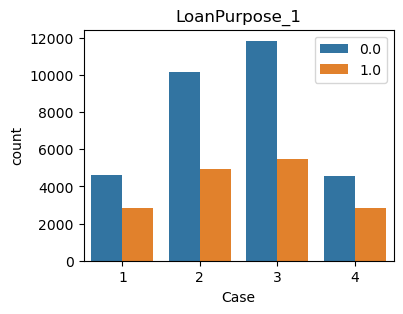



LoanPurpose_2: found a statistical difference in the means, with p value: 7.494596384020128e-55

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


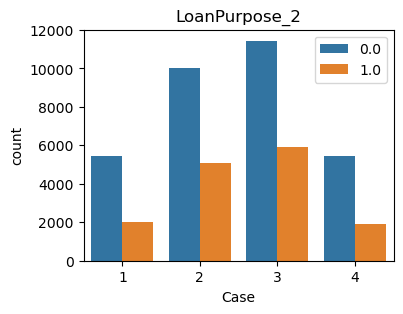



LoanPurpose_6: found a statistical difference in the means, with p value: 0.010597789943718086

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 2 and Dataset 4


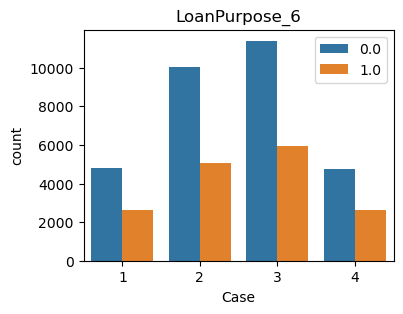



MortgageType_0: found a statistical difference in the means, with p value: 2.0977168897834124e-36

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


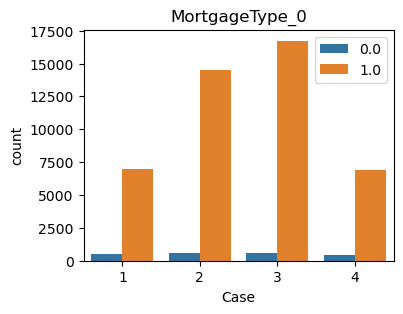



MortgageType_infrequent_sklearn: found a statistical difference in the means, with p value: 2.0977168897834124e-36

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


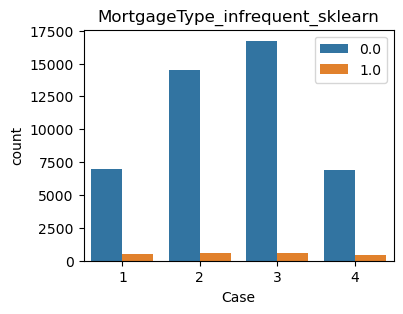



Gender1_1: found a statistical difference in the means, with p value: 0.006429344131375477

There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


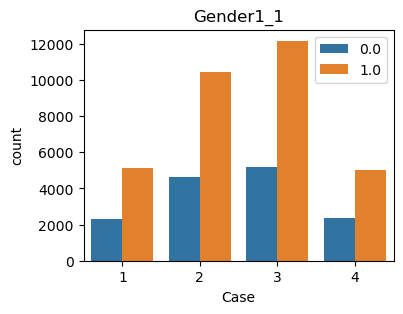



Gender1_2: found a statistical difference in the means, with p value: 0.016954065628053086

There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


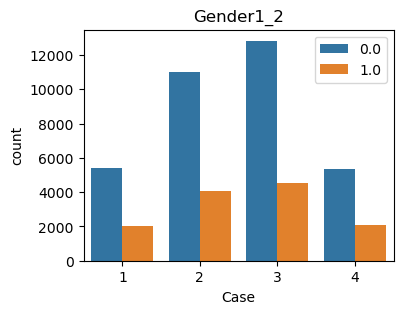



Gender2_2: found a statistical difference in the means, with p value: 3.826162204596489e-15

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 1 and Dataset 4
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


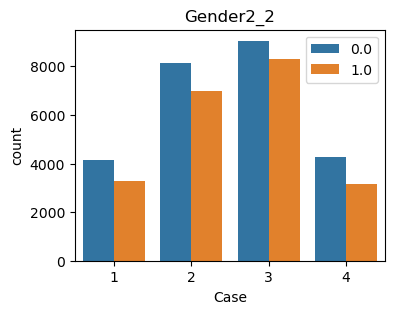



Gender2_3: found a statistical difference in the means, with p value: 0.038182336918789514

There is evidence of a difference in distributions between Dataset 1 and Dataset 3


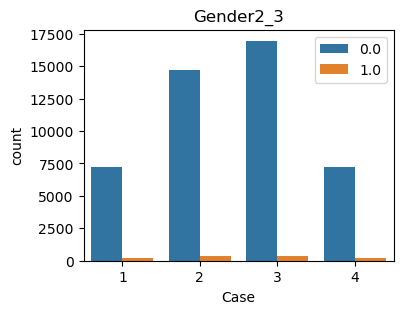



Gender2_4: found a statistical difference in the means, with p value: 6.650747465009793e-13

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


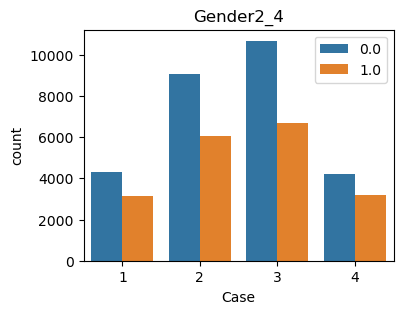



PropertyType_infrequent_sklearn: found a statistical difference in the means, with p value: 6.926236097454832e-05

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


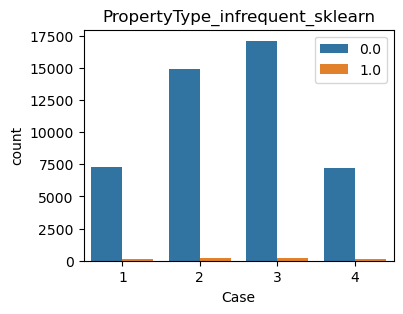



Race1_5: found a statistical difference in the means, with p value: 0.0917602161457338

There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


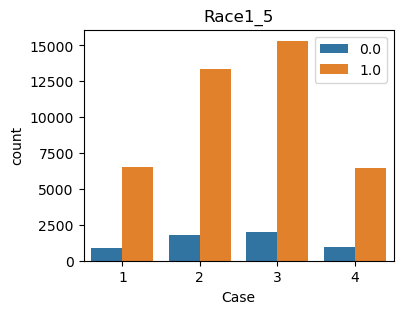



Race1_infrequent_sklearn: found a statistical difference in the means, with p value: 0.001994653473328478

There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


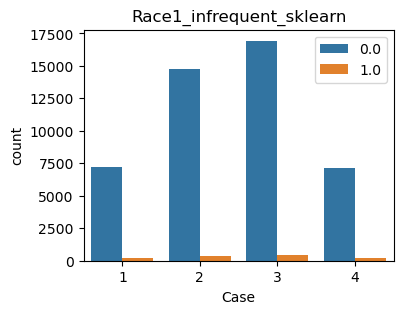



Minority2_Missing: found a statistical difference in the means, with p value: 4.053108356573357e-14

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


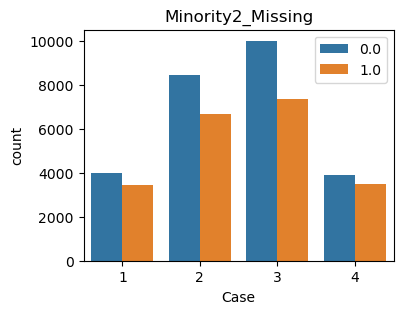



Minority2_White: found a statistical difference in the means, with p value: 1.257919428134146e-13

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


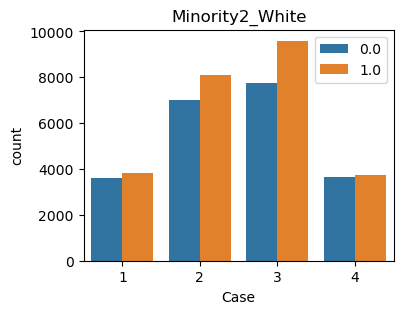



Race2_5: found a statistical difference in the means, with p value: 1.257919428134146e-13

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


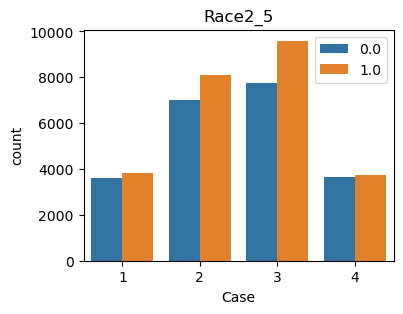



Race2_8: found a statistical difference in the means, with p value: 6.966199260191275e-13

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


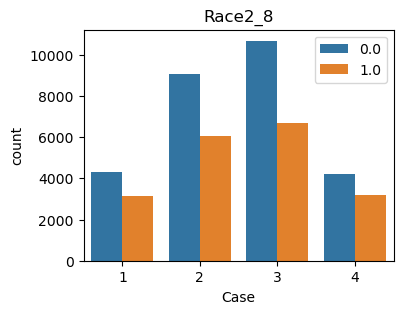



State_6: found a statistical difference in the means, with p value: 3.25564969031529e-05

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


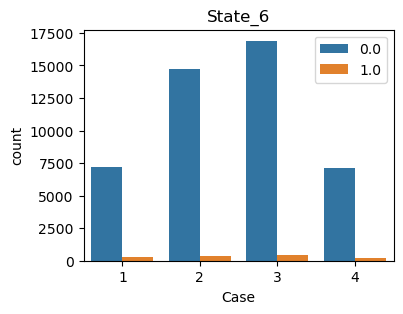



State_8: found a statistical difference in the means, with p value: 2.2907204522552443e-08

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


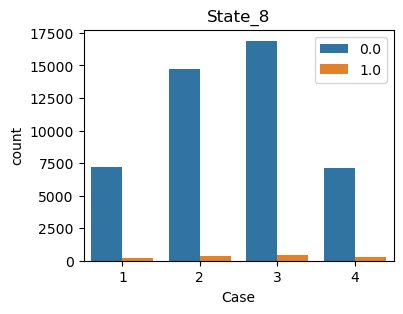



State_17: found a statistical difference in the means, with p value: 0.036649917614642036

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 2 and Dataset 3


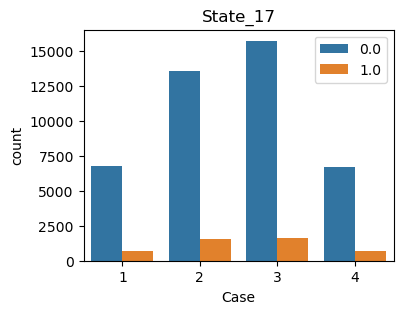



State_18: found a statistical difference in the means, with p value: 4.1434998920146895e-11

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


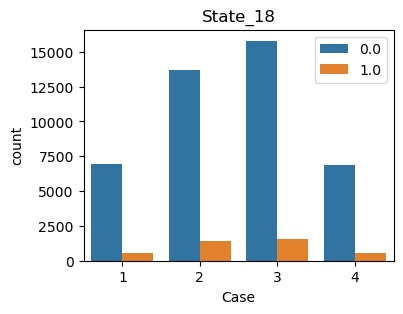



State_19: found a statistical difference in the means, with p value: 0.031203563453292497

There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


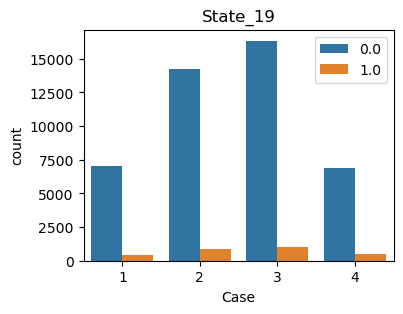



State_20: found a statistical difference in the means, with p value: 0.012607299189286499

There is evidence of a difference in distributions between Dataset 2 and Dataset 3


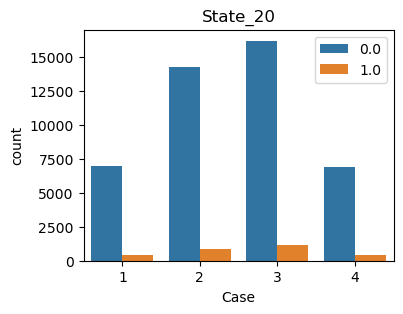



State_26: found a statistical difference in the means, with p value: 2.7717806561440424e-05

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


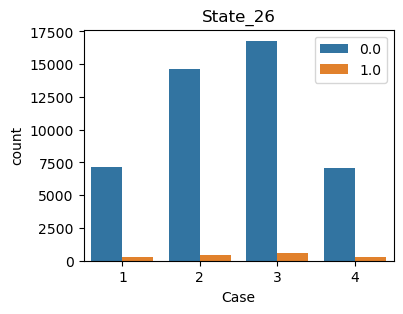



State_31: found a statistical difference in the means, with p value: 0.00046202945263015675

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 2 and Dataset 3


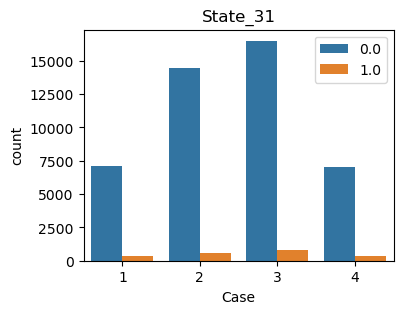



State_39: found a statistical difference in the means, with p value: 5.913101747278067e-26

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


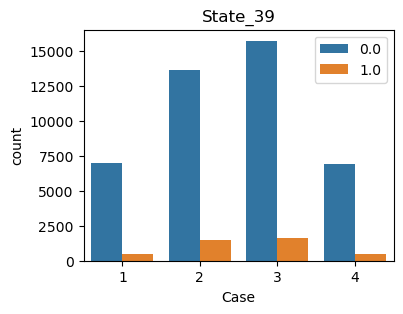



State_42: found a statistical difference in the means, with p value: 1.0223529392678288e-05

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


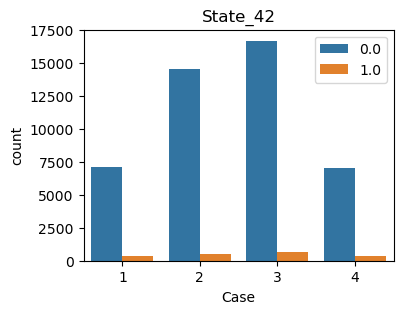



State_48: found a statistical difference in the means, with p value: 2.8951213467032315e-06

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


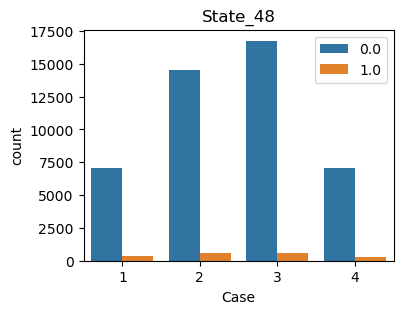



State_55: found a statistical difference in the means, with p value: 2.4472122193119697e-21

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


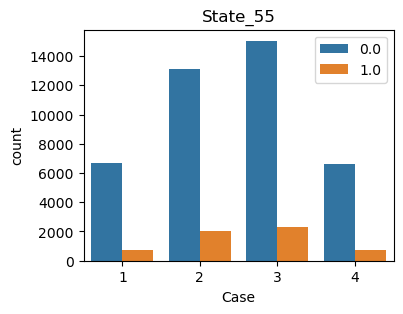



State_infrequent_sklearn: found a statistical difference in the means, with p value: 3.308611960070887e-16

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


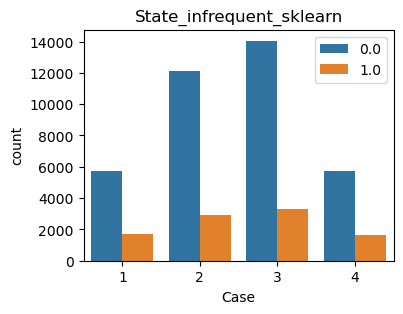



Minority_Min: found a statistical difference in the means, with p value: 0.020848001806587697

There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


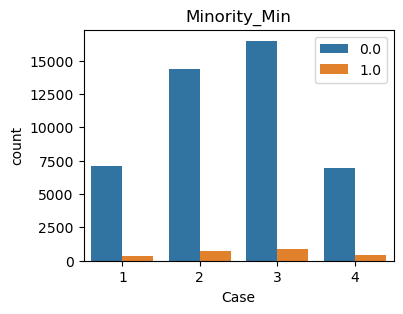



Minority_White: found a statistical difference in the means, with p value: 0.0917602161457338

There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


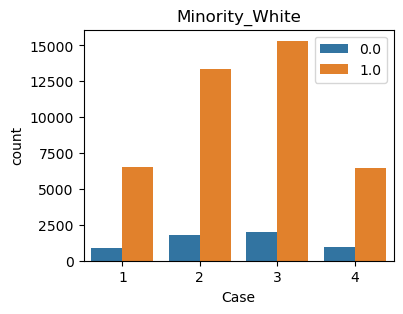



Borrower2Dummy: found a statistical difference in the means, with p value: 3.528245231988341e-13

There is evidence of a difference in distributions between Dataset 1 and Dataset 2
There is evidence of a difference in distributions between Dataset 1 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 3
There is evidence of a difference in distributions between Dataset 2 and Dataset 4
There is evidence of a difference in distributions between Dataset 3 and Dataset 4


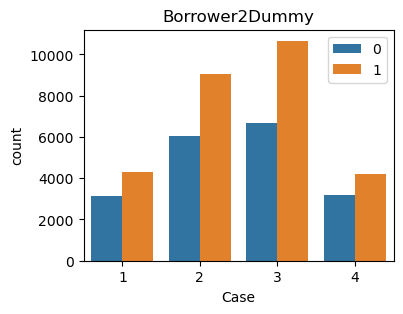

In [41]:
counter, different_vars = 0, []
for var_name in categorical: 

    data = {'Group1': data_test.loc[indexes['1'],var_name].dropna().tolist(),
            'Group2': data_test.loc[indexes['2'],var_name].dropna().tolist(),
            'Group3': data_test.loc[indexes['3'],var_name].dropna().tolist(),
            'Group4': data_test.loc[indexes['4'],var_name].dropna().tolist()}
    
    # Perform ANOVA test
    h_statistic, p_value = stats.kruskal(data['Group1'], data['Group2'], data['Group3'], data['Group4'])    # f_oneway

    if p_value < 0.1: 
        counter +=1
        different_vars.append(var_name)
        print(f"\n\n{var_name}: found a statistical difference in the means, with p value: {p_value}\n") 
        
        
        # Perform pairwise KS tests
        data = [data['Group1'], data['Group2'], data['Group3'], data['Group4']]
        for i, dataset1 in enumerate(data):
            for j, dataset2 in enumerate(data):
                if i < j:
                    t_statistic, p_value = stats.ttest_ind(dataset1, dataset2)
                    '''print(f"KS Test between Dataset {i+1} and Dataset {j+1}:")
                    print(f"KS Statistic: {ks_statistic}")
                    print(f"P-value: {p_value}")'''
                    if p_value < 0.05:  # Set your desired significance level
                        print(f"There is evidence of a difference in distributions between Dataset {i+1} and Dataset {j+1}")
                    else:
                        pass #print("No significant difference in distributions.\n")

        
        plt.figure(figsize=(4,3))
        ax = sns.countplot(x=model, data=data_test, hue=var_name) 
        plt.title(var_name) 
        plt.xlabel('Case')
        plt.legend(title=None)
        plt.show()
        # plot box plots 
        #data = [data['Group1'], data['Group2'], data['Group3'], data['Group4']]
        '''plt.figure(figsize=(4, 4))
        plt.violinplot(data, showmedians=True, showmeans=False)#, labels=['Case 1', 'Case 2', 'Case 3', 'Case 4'])
        plt.xlabel("Groups")
        plt.ylabel("Values: "+var_name)
        plt.title("Comparison of Means among Multiple Groups: "+var_name)
        plt.show()'''
        

In [35]:
print(f"Statistical difference in means found in {counter} variables: \n{different_vars}")

Statistical difference in means found in 41 variables: 
['BorrowerCount', 'FirstTime', 'SelfEmployed', 'Bank_Chicago', 'Bank_Cincinnati', 'Bank_Dallas', 'Bank_Pittsburgh', 'Bank_Topeka', 'LoanPurpose_1', 'LoanPurpose_2', 'LoanPurpose_6', 'MortgageType_0', 'MortgageType_infrequent_sklearn', 'Gender1_1', 'Gender1_2', 'Gender2_2', 'Gender2_3', 'Gender2_4', 'PropertyType_infrequent_sklearn', 'Race1_5', 'Race1_infrequent_sklearn', 'Minority2_Missing', 'Minority2_White', 'Race2_5', 'Race2_8', 'State_6', 'State_8', 'State_17', 'State_18', 'State_19', 'State_20', 'State_26', 'State_31', 'State_39', 'State_42', 'State_48', 'State_55', 'State_infrequent_sklearn', 'Minority_Min', 'Minority_White', 'Borrower2Dummy']
